In [125]:
import torch
import torch.nn as nn
import torch.nn.functional as F 

import os
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np
import struct
from PIL import Image

from torchvision.models import resnet18
import matplotlib.pyplot as plt

# **DATASET CLASS**

In [126]:
class MNISTDataset(Dataset):
    def __init__(self, images_path, labels_path, image_size=28):
        self.images_path = images_path
        self.labels_path = labels_path
        self.image_size = image_size

        self.images = self._read_images(self.images_path)
        self.labels = self._read_labels(self.labels_path)

        self.transform = transforms.Compose([
            transforms.Resize((self.image_size, self.image_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])

    def _read_images(self, filepath):
        with open(filepath, 'rb') as f:
            magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
            images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, 28, 28)
        return images

    def _read_labels(self, filepath):
        with open(filepath, 'rb') as f:
            magic, num = struct.unpack(">II", f.read(8))
            labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        image = Image.fromarray(image, mode='L')

        if self.transform:
            image = self.transform(image)

        return image, label

# **CNN CLASSIFIER**

In [127]:
class MnistClassifier(nn.Module):

	def __init__(self, num_classes=10):
		super(MnistClassifier, self).__init__()

		self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
		self.pool = nn.MaxPool2d(2, 2)

		self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
		self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

		self.fc1 = nn.Linear(64 * 3 * 3, 64)
		self.fc2 = nn.Linear(64, num_classes)

	def forward(self, x):
		x = self.conv1(x)
		x = F.relu(x)
		x = self.pool(x)

		x = self.conv2(x)
		x = F.relu(x)
		x = self.pool(x)

		x = self.conv3(x)
		x = F.relu(x)
		x = self.pool(x)

		x = x.view(x.size(0), -1)
		x = self.fc1(x)
		x = F.relu(x)

		x = self.fc2(x)

		return x

# **TRAINING**

In [128]:
import argparse
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

train_dataset = MNISTDataset(
    images_path='/kaggle/input/mnist-dataset/train-images-idx3-ubyte/train-images-idx3-ubyte',
    labels_path='/kaggle/input/mnist-dataset/train-labels-idx1-ubyte/train-labels-idx1-ubyte'
)

test_dataset = MNISTDataset(
    images_path='/kaggle/input/mnist-dataset/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte',
    labels_path='/kaggle/input/mnist-dataset/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte'
)

batch_size = 8 
test_batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=test_batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 10

model = MnistClassifier(num_classes)
model = model.to(device)


# **Fungsi Loss dan Algoritma optimizer**

In [129]:
#ini adalah fungsi loss
criterion = nn.CrossEntropyLoss()

#algoritma optimasi
#gradient descent
lr = 1e-4  # Learning Rate 
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)


# **Menghitung jumlah parameter yang dioptimasi (Update)**

In [130]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params / 1e6:.2f}M")
print(f"Trainable parameters: {trainable_params / 1e6:.2f}M")

Total parameters: 0.06M
Trainable parameters: 0.06M


100%|██████████| 1250/1250 [00:02<00:00, 451.55it/s]


Epoch 1: Train Loss 0.2858, Test Loss 0.0799, Test Acc 0.9751


100%|██████████| 1250/1250 [00:02<00:00, 452.16it/s]


Epoch 2: Train Loss 0.0762, Test Loss 0.0522, Test Acc 0.9840


100%|██████████| 1250/1250 [00:02<00:00, 460.73it/s]


Epoch 3: Train Loss 0.0524, Test Loss 0.0388, Test Acc 0.9861


100%|██████████| 1250/1250 [00:02<00:00, 460.10it/s]


Epoch 4: Train Loss 0.0415, Test Loss 0.0330, Test Acc 0.9887


100%|██████████| 1250/1250 [00:02<00:00, 452.37it/s]


Epoch 5: Train Loss 0.0327, Test Loss 0.0299, Test Acc 0.9900


100%|██████████| 1250/1250 [00:02<00:00, 452.53it/s]


Epoch 6: Train Loss 0.0284, Test Loss 0.0267, Test Acc 0.9910


100%|██████████| 1250/1250 [00:02<00:00, 446.95it/s]


Epoch 7: Train Loss 0.0228, Test Loss 0.0329, Test Acc 0.9893


100%|██████████| 1250/1250 [00:02<00:00, 443.54it/s]


Epoch 8: Train Loss 0.0202, Test Loss 0.0265, Test Acc 0.9902


100%|██████████| 1250/1250 [00:03<00:00, 405.49it/s]


Epoch 9: Train Loss 0.0173, Test Loss 0.0368, Test Acc 0.9884


100%|██████████| 1250/1250 [00:02<00:00, 450.41it/s]


Epoch 10: Train Loss 0.0151, Test Loss 0.0285, Test Acc 0.9911


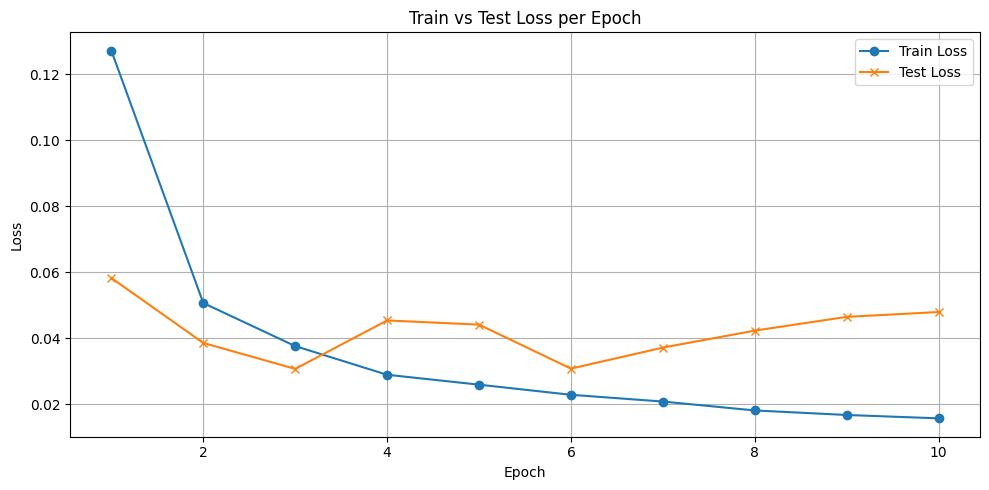

In [131]:
num_epoch = 10
train_losses = []
test_losses = []

for epoch in range(num_epoch):
	model.train()

	train_loss = 0

	for data, labels in tqdm(train_loader):

		data, labels = data.to(device), labels.to(device)
		bs = data.size()[0]
		optimizer.zero_grad()

		outputs = model(data)
		loss = criterion(outputs, labels)

		loss.backward()

		optimizer.step()

		train_loss += loss.item() * data.size(0)

	model.eval()

	correct = 0
	total = 0
	test_loss = 0

	with torch.no_grad():
		for data, labels in tqdm(test_loader):
			data, labels = data.to(device), labels.to(device)
			bs = data.size()[0]
			outputs = model(data)

			loss = criterion(outputs, labels)
			test_loss += loss.item() * data.size(0)

			_, preds = torch.max(outputs, 1)
			correct += (preds == labels).sum().item()

			total += labels.size(0)

	acc = correct / total
	avg_train_loss = train_loss / len(train_dataset)
	avg_test_loss = test_loss / len(test_dataset)

	train_losses.append(avg_train_loss)
	test_losses.append(avg_test_loss)

	print(f"Epoch {epoch+1}: Train Loss {avg_train_loss:.4f}, Test Loss {avg_test_loss:.4f}, Test Acc {acc:.4f}")

torch.save({
    'epoch': num_epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_losses,
    'test_loss': test_losses,
}, 'CNN-MNIST.pth')

# ================================
# Plot Loss per Epoch
# ================================
epochs_range = range(1, n_epoch + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_loss_per_epoch, label='Train Loss', marker='o')
plt.plot(epochs_range, test_loss_per_epoch, label='Test Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# **MODEL EVALUATION**

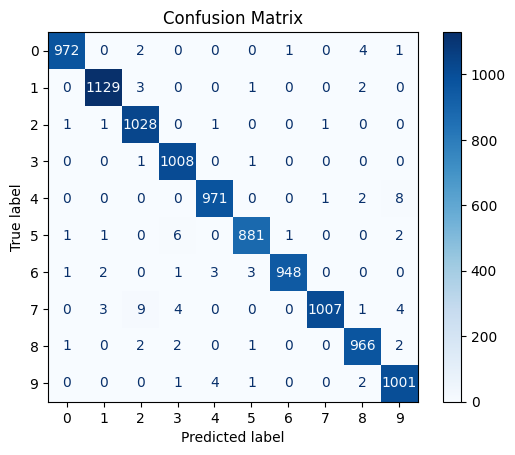

In [132]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, 
    f1_score, classification_report
)
import matplotlib.pyplot as plt

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5,6,7,8,9])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [133]:
print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision (macro): {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"Recall (macro): {recall_score(y_true, y_pred, average='macro'):.4f}")
print(f"F1-Score (macro): {f1_score(y_true, y_pred, average='macro'):.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred))


FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FPR = FP / (FP + TN)
TPR = TP / (TP + FN)

for i in range(len(TP)):
    print(f"Kelas {i}: FPR = {FPR[i]:.4f}, TPR (Recall) = {TPR[i]:.4f}")

Accuracy: 0.9911
Precision (macro): 0.9912
Recall (macro): 0.9910
F1-Score (macro): 0.9911

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      1.00      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       1.00      0.98      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.98      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

Kelas 0: FPR = 0.0004, TPR (Recall) = 0.9918
Kelas 1: FPR = 0.0008, TPR (Recall) = 0.9947
Kelas 2: FPR = 0.0019, TPR (Recall) 